<a href="https://colab.research.google.com/github/thaCripple/CCC_Image_Classifier/blob/main/CCC_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Transfer learning with PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2

In [2]:
from pathlib import Path
import os

In [3]:
!pip install -q torchmetrics
import torchmetrics

# Import EfficientNet_B0

## Let's see what the required transforms do

In [4]:
from PIL import Image

In [5]:
effnet_tranforms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms() # Don't forget the () at the end!

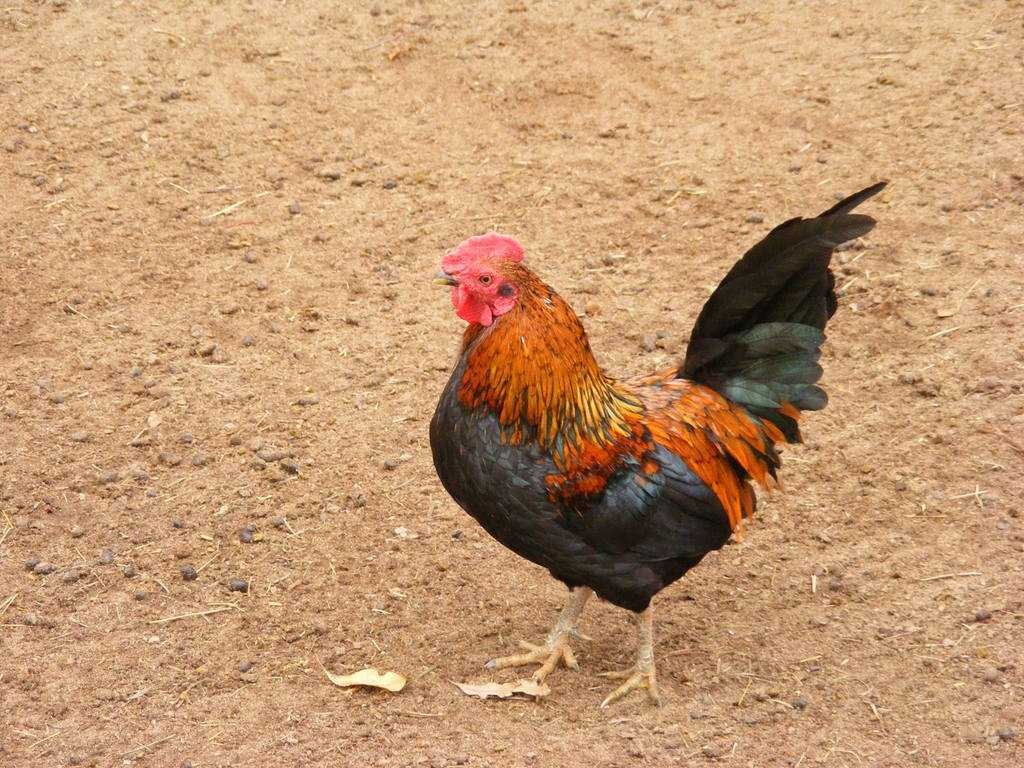

In [6]:
sample_img = Image.open("/content/drive/MyDrive/ccc_images/test/chicken/0L6FFWDX5V3P.jpg")
sample_img

In [7]:
sample_img_transformed = effnet_tranforms(sample_img)
sample_img_transformed

tensor([[[1.8379, 1.7180, 1.5982,  ..., 1.9407, 1.9064, 1.7523],
         [1.7694, 1.8722, 1.6153,  ..., 1.7523, 1.8893, 1.8208],
         [1.6495, 1.7352, 1.8379,  ..., 1.7865, 1.8208, 1.6838],
         ...,
         [1.4440, 1.7180, 1.8037,  ..., 1.4783, 1.3755, 1.3242],
         [1.3584, 1.6838, 1.5810,  ..., 1.5639, 1.6495, 1.6324],
         [1.3927, 1.4783, 1.3242,  ..., 1.5125, 1.3413, 1.4269]],

        [[1.2731, 1.1155, 0.9930,  ..., 1.5182, 1.4832, 1.3081],
         [1.2206, 1.2556, 1.0105,  ..., 1.2906, 1.4307, 1.3606],
         [1.1155, 1.1681, 1.2906,  ..., 1.2556, 1.2906, 1.1506],
         ...,
         [0.8704, 1.0980, 1.1681,  ..., 0.9580, 0.8354, 0.7654],
         [0.7829, 1.0630, 0.9405,  ..., 1.0455, 1.1331, 1.1155],
         [0.8179, 0.8354, 0.6779,  ..., 0.9930, 0.8179, 0.9055]],

        [[0.7402, 0.6008, 0.4788,  ..., 0.9494, 0.9145, 0.7576],
         [0.6879, 0.7576, 0.5136,  ..., 0.7402, 0.8797, 0.8099],
         [0.5834, 0.6531, 0.7751,  ..., 0.7228, 0.7576, 0.

In [8]:
# Change to Channels Last
sample_img_transformed = torch.movedim(input=sample_img_transformed, source=0, destination=-1)

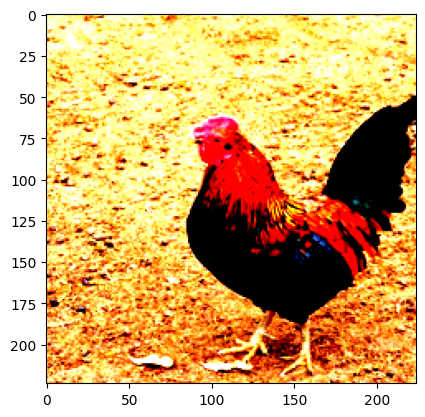

In [9]:
plt.figure()
plt.imshow(sample_img_transformed)

# Prepare the Image Data for the Feature Extractor

In [10]:
IMAGES_PATH = Path("/content/drive/MyDrive/ccc_images")
IMAGES_PATH

PosixPath('/content/drive/MyDrive/ccc_images')

In [11]:
train_imgs_dir = IMAGES_PATH / "train"
test_imgs_dir = IMAGES_PATH / "test"

In [12]:
BATCH_SIZE = 16
WORKERS = os.cpu_count()

In [13]:
train_ds = torchvision.datasets.ImageFolder(root=train_imgs_dir, transform=effnet_tranforms)
test_ds = torchvision.datasets.ImageFolder(root=test_imgs_dir, transform=effnet_tranforms)

In [14]:
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, prefetch_factor=2, pin_memory=True)
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, prefetch_factor=2, pin_memory=True)

# Feature Extractor

In [15]:
effnet_model_feature_extractor = torchvision.models.efficientnet_b0(weights="DEFAULT")

Freeze all of the base model's layers

In [16]:
for param in effnet_model_feature_extractor.parameters():
  param.requires_grad = False

Replace the original Classification layer

In [17]:
classifier_input_size = effnet_model_feature_extractor.classifier[1].in_features
classifier_input_size

1280

In [18]:
effnet_model_feature_extractor.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [19]:
effnet_model_feature_extractor.classifier[1] = nn.Linear(in_features=classifier_input_size, out_features=3, bias=True)

In [20]:
effnet_model_feature_extractor.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

Compile the model and move it to the GPU

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
effnet_model_feature_extractor = torch.compile(effnet_model_feature_extractor.to(device=device, non_blocking=True))

## Define the loss function and optimizer

In [23]:
effnet_model_feature_extractor_loss_fn = nn.CrossEntropyLoss()
effnet_model_feature_extractor_optim = torch.optim.Adam(effnet_model_feature_extractor.parameters(), lr=0.0005)

Define the accuracy function

In [31]:
# accuracy_fn = torchmetrics.functional.classification.multiclass_accuracy(num_classes=3, average='micro')
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=3, average='micro').to(device=device, non_blocking=True)

# Define train and test functions

In [32]:
def train_step(model:nn.Module, train_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss, optimizer:torch.optim, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)-> tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_dl)

  model.train()
  for x_batch, y_batch in train_dl:
    x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    total_epoch_loss += loss.item()

    accuracy = accuracy_fn(preds=logits, target=y_batch)
    total_epoch_accuracy += accuracy.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy


def test_step(model:nn.Module, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss, accuracy_fn:torchmetrics.classification.MulticlassAccuracy, device:str=device)-> tuple:

  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(test_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)

      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)
      total_epoch_loss += loss.item()

      accuracy = accuracy_fn(preds=logits, target=y_batch)
      total_epoch_accuracy += accuracy.item()

    mean_epoch_loss = total_epoch_loss / num_batches
    mean_epoch_accuracy = total_epoch_accuracy / num_batches

  return mean_epoch_loss, mean_epoch_accuracy

# Define the training loop function

In [33]:
def train_model(*,
                epochs:int=1,
                model:nn.Module,
                train_dl:torch.utils.data.DataLoader,
                test_dl:torch.utils.data.DataLoader,
                loss_fn:nn.modules.loss,
                optimizer:torch.optim,
                accuracy_fn:torchmetrics.classification.MulticlassAccuracy=accuracy_fn,
                device:str=device)->dict:

  train_metrics = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": [],
  }

  for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs-1}")

    train_loss, train_accuracy = train_step(model=model, train_dl=train_dl, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    test_loss, test_accuracy = test_step(model=model, test_dl=test_dl, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

    train_metrics["train_loss"].append(train_loss)
    train_metrics["train_accuracy"].append(train_accuracy)
    train_metrics["test_loss"].append(test_loss)
    train_metrics["test_accuracy"].append(test_accuracy)

    print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_accuracy:.2f}")
    print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_accuracy:.2f}")
    print("-"*80)

  return train_metrics

# Train the new model with EfficientNetB0 as a Feature Extactor

In [34]:
effnet_model_feature_extractor_epochs = 5

In [35]:
effnet_model_feature_extractor_train_history = train_model(
    epochs=effnet_model_feature_extractor_epochs,
    model=effnet_model_feature_extractor,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=effnet_model_feature_extractor_loss_fn,
    optimizer=effnet_model_feature_extractor_optim,
    accuracy_fn=accuracy_fn,
    device=device)

Epoch 0/4
Train loss: 0.870 | Train accuracy: 0.74
Test loss: 0.585 | Test accuracy: 0.97
--------------------------------------------------------------------------------
Epoch 1/4
Train loss: 0.553 | Train accuracy: 0.92
Test loss: 0.379 | Test accuracy: 0.98
--------------------------------------------------------------------------------
Epoch 2/4
Train loss: 0.392 | Train accuracy: 0.94
Test loss: 0.277 | Test accuracy: 0.97
--------------------------------------------------------------------------------
Epoch 3/4
Train loss: 0.287 | Train accuracy: 0.97
Test loss: 0.217 | Test accuracy: 0.98
--------------------------------------------------------------------------------
Epoch 4/4
Train loss: 0.219 | Train accuracy: 0.99
Test loss: 0.181 | Test accuracy: 0.99
--------------------------------------------------------------------------------


# Plot the training history of the model

In [36]:
effnet_model_feature_extractor_train_history

{'train_loss': [0.8701562370572772,
  0.5531181991100311,
  0.3923559273992266,
  0.28672563816819874,
  0.21930788741225288],
 'train_accuracy': [0.7357804235957918,
  0.9150132281439645,
  0.9447751329058692,
  0.9708994712148394,
  0.9880952380952381],
 'test_loss': [0.5845843613147735,
  0.3789393723011017,
  0.2773838073015213,
  0.21734684109687805,
  0.18070984855294228],
 'test_accuracy': [0.975, 0.98125, 0.975, 0.98125, 0.9875]}

In [47]:
x_ticks = np.arange(0, len(effnet_model_feature_extractor_train_history["train_loss"]), 1)
x_ticks

array([0, 1, 2, 3, 4])

In [52]:
def plot_history(history_dict:dict)->None:
  # Make x ticks be integers and correspond to actual epoch numbers
  x_ticks = np.arange(0, len(history_dict["train_loss"]), 1)

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  # Plot the loss curves
  ax[0].plot(x_ticks, history_dict["train_loss"], color="green", label="Train Loss")
  ax[0].plot(x_ticks, history_dict["test_loss"], color="blue", label="Test Loss")
  ax[0].set_xticks(ticks=x_ticks)
  ax[0].legend()

  # Plot the accuracy curves
  ax[1].plot(x_ticks, history_dict["train_accuracy"], color="green", label="Train Accuracy")
  ax[1].plot(x_ticks, history_dict["test_accuracy"], color="blue", label="Test Accuracy")
  ax[1].set_xticks(ticks=x_ticks)
  ax[1].legend()

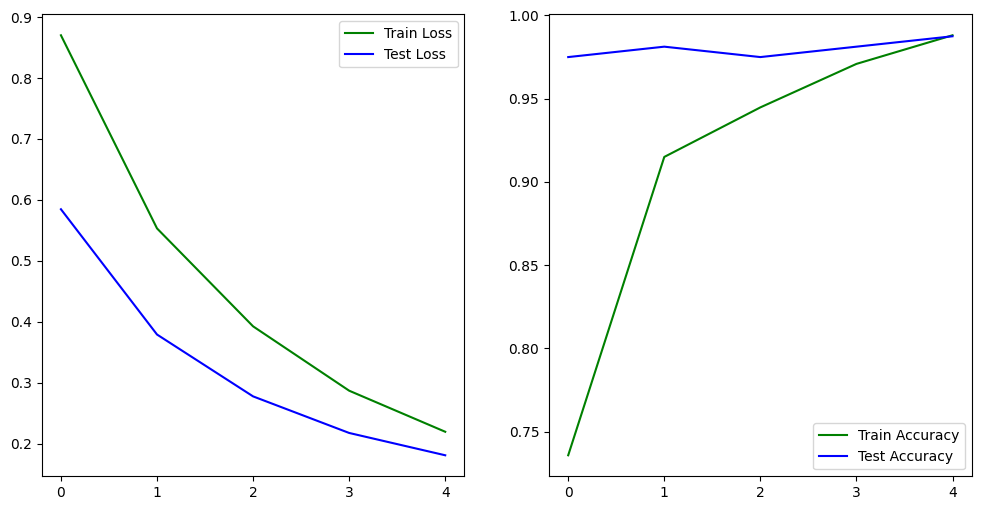

In [53]:
plot_history(effnet_model_feature_extractor_train_history)

# Evaluate the model's performance

In [54]:
from sklearn.metrics import classification_report

In [55]:
def get_predictions(model:nn.Module, test_dl:torch.utils.data.DataLoader, device:str=device)->torch.Tensor:

  model.eval()
  with torch.inference_mode():
    batched_predictions = []
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device, non_blocking=True), y_batch.to(device=device, non_blocking=True)
      batch_logits = model(x_batch)
      batch_predictions = torch.argmax(batch_logits, dim=1)
      batched_predictions.append(batch_predictions)

  predictions = torch.cat(batched_predictions, dim=0).to(device="cpu")
  return predictions

In [56]:
effnet_model_feature_extractor_test_predictions = get_predictions(model=effnet_model_feature_extractor, test_dl=test_dl)

In [60]:
effnet_model_feature_extractor_test_predictions

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [70]:
y_true = test_ds.targets

In [71]:
y_labels = test_ds.classes
y_labels

['cat', 'chicken', 'cow']

In [72]:
print(classification_report(y_true=y_true, y_pred=effnet_model_feature_extractor_test_predictions, target_names=y_labels))

              precision    recall  f1-score   support

         cat       0.96      1.00      0.98        50
     chicken       1.00      0.96      0.98        50
         cow       1.00      1.00      1.00        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# Finetuning the Entire EfficientNet

### Create a new instance of the model

In [74]:
effnet_model_finetune = torchvision.models.efficientnet_b0(weights="DEFAULT")

Replace the original Classification layer

In [75]:
classifier_input_size = effnet_model_finetune.classifier[1].in_features
classifier_input_size

1280

In [76]:
effnet_model_finetune.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [77]:
effnet_model_finetune.classifier[1] = nn.Linear(in_features=classifier_input_size, out_features=3, bias=True)

In [78]:
effnet_model_finetune.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

Compile the model and move it to the GPU

In [79]:
effnet_model_finetune = torch.compile(effnet_model_finetune.to(device=device, non_blocking=True))

## Define the loss function and optimizer

In [80]:
effnet_model_finetune_loss_fn = nn.CrossEntropyLoss()

# Setting a lower learning rate than for the feature extactor
effnet_model_finetune_optim = torch.optim.Adam(effnet_model_finetune.parameters(), lr=0.0001)

# Train the new model to Finetune the EfficientNetB0 to our Dataset

In [81]:
effnet_model_finetune_epochs = 5

In [82]:
effnet_model_finetune_train_history = train_model(
    epochs=effnet_model_finetune_epochs,
    model=effnet_model_finetune,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_fn=effnet_model_finetune_loss_fn,
    optimizer=effnet_model_finetune_optim,
    accuracy_fn=accuracy_fn,
    device=device)

Epoch 0/4
Train loss: 0.861 | Train accuracy: 0.71
Test loss: 0.496 | Test accuracy: 0.97
--------------------------------------------------------------------------------
Epoch 1/4
Train loss: 0.423 | Train accuracy: 0.96
Test loss: 0.211 | Test accuracy: 0.99
--------------------------------------------------------------------------------
Epoch 2/4
Train loss: 0.190 | Train accuracy: 0.99
Test loss: 0.091 | Test accuracy: 0.99
--------------------------------------------------------------------------------
Epoch 3/4
Train loss: 0.103 | Train accuracy: 0.99
Test loss: 0.059 | Test accuracy: 1.00
--------------------------------------------------------------------------------
Epoch 4/4
Train loss: 0.055 | Train accuracy: 1.00
Test loss: 0.045 | Test accuracy: 1.00
--------------------------------------------------------------------------------


# Plot the training history

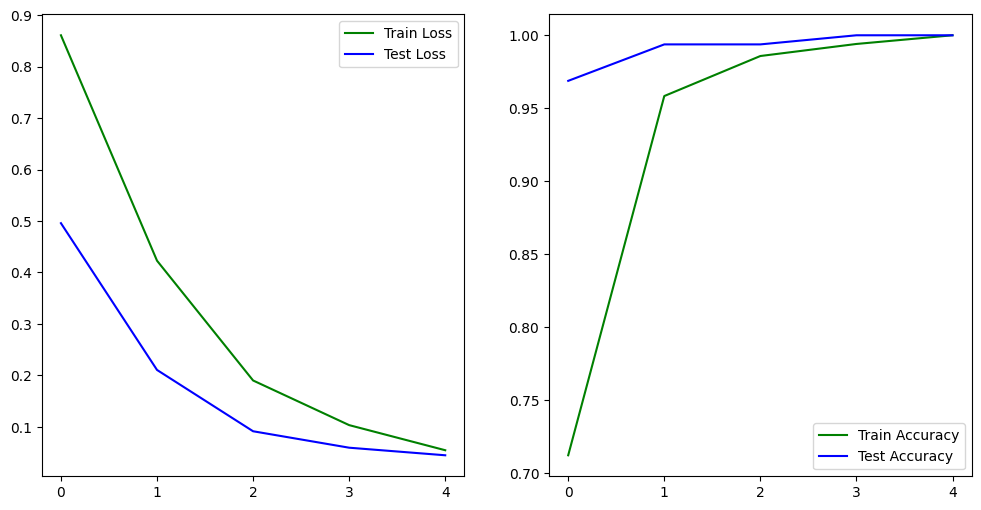

In [83]:
plot_history(effnet_model_finetune_train_history)

# Evaluate the model's performance

In [84]:
effnet_model_finetune_test_predictions = get_predictions(model=effnet_model_finetune, test_dl=test_dl)

In [85]:
effnet_model_finetune_test_predictions

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [86]:
y_true = test_ds.targets

In [87]:
y_labels = test_ds.classes
y_labels

['cat', 'chicken', 'cow']

In [88]:
print(classification_report(y_true=y_true, y_pred=effnet_model_finetune_test_predictions, target_names=y_labels))

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00        50
     chicken       1.00      1.00      1.00        50
         cow       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



# Conclusions

* Compiling the model seems to result in a very lengthy runtime for the 1st epoch and a significant speedup of the subsequent epochs suggesting that benefits will be seen only with longer training cycles

* Both the feature extactor and finetuning resulted in models that performed exceptionally well even after 5 epochs of training. That is likely the result of the fact that my Test Dataset consisted of images that were probably largely present in the ImageNet. Although the *cows* were from some study and were definitely not from ImageNet and the model had no problems calssifying those